<a href="https://colab.research.google.com/github/ShahistaAfreen/Credit-Risk-Scoring-with-Explainable-AI/blob/main/Credit_Risk_Scoring_with_Explainable_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
# 1) Environment
# If running locally the first time, uncomment:
# %pip install -q numpy pandas scikit-learn imbalanced-learn xgboost shap matplotlib joblib

import warnings, json, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from typing import Dict
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (
    roc_auc_score, average_precision_score, roc_curve,
    accuracy_score, precision_score, recall_score, f1_score
)
import shap, joblib

warnings.filterwarnings("ignore")
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [23]:
# 2) Data Config
df = pd.read_csv('credit_data.csv')

# Drop unwanted index column if present
if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])

# Convert target 'Risk' to binary (1 = bad, 0 = good)
df["Risk"] = df["Risk"].str.strip().str.lower().map({"good": 0, "bad": 1})

# Define target
TARGET = "Risk"

print("Shape:", df.shape)
print(df[TARGET].value_counts(normalize=True))

df.head()


Shape: (1000, 10)
Risk
0    0.7
1    0.3
Name: proportion, dtype: float64


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,0
1,22,female,2,own,little,moderate,5951,48,radio/TV,1
2,49,male,1,own,little,NaN,2096,12,education,0
3,45,male,2,free,little,little,7882,42,furniture/equipment,0
4,53,male,2,free,little,little,4870,24,car,1


In [25]:
# 3) Split & Preprocess
X = df.drop(columns=[TARGET])
y = df[TARGET].values

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

numeric = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=False))
])

categorical = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=True))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric, num_cols),
        ("cat", categorical, cat_cols)
    ],
    sparse_threshold=0.3,
    remainder="drop"
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

print(f"Train: {X_train.shape}, Test: {X_test.shape}")

Train: (800, 9), Test: (200, 9)


In [26]:
# 4) Helpers
def positive_weight(y):
    pos = (y==1).sum()
    neg = (y==0).sum()
    return neg / max(pos, 1)

def evaluate(model_name, pipe):
    pipe.fit(X_train, y_train)
    proba = pipe.predict_proba(X_test)[:, 1]
    pred  = (proba >= 0.5).astype(int)
    m: Dict[str, float] = {
        "model": model_name,
        "auc_roc": roc_auc_score(y_test, proba),
        "auc_pr":  average_precision_score(y_test, proba),
        "accuracy": accuracy_score(y_test, pred),
        "precision_pos": precision_score(y_test, pred, pos_label=1, zero_division=0),
        "recall_pos":    recall_score(y_test, pred, pos_label=1, zero_division=0),
        "f1_pos":        f1_score(y_test, pred, pos_label=1, zero_division=0),
    }
    return m, pipe, proba, pred


In [27]:
# 5) Models: Cost-Sensitive
scale_pos = positive_weight(y_train)

logreg_cs = Pipeline([
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced"))
])

rf_cs = Pipeline([
    ("prep", preprocess),
    ("clf", RandomForestClassifier(
        n_estimators=300, n_jobs=-1, random_state=RANDOM_STATE, class_weight="balanced"
    ))
])

xgb_cs = Pipeline([
    ("prep", preprocess),
    ("clf", XGBClassifier(
        n_estimators=500, max_depth=6, learning_rate=0.05, subsample=0.9, colsample_bytree=0.9,
        reg_lambda=1.0, min_child_weight=1.0, random_state=RANDOM_STATE, n_jobs=-1,
        tree_method="hist", eval_metric="logloss", scale_pos_weight=scale_pos
    ))
])


In [28]:
# 6) Models: SMOTE + Classifier
smote = SMOTE(random_state=RANDOM_STATE, k_neighbors=5)

logreg_smote = Pipeline([
    ("prep", preprocess),
    ("smote", smote),
    ("clf", LogisticRegression(max_iter=2000))
])

rf_smote = Pipeline([
    ("prep", preprocess),
    ("smote", smote),
    ("clf", RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=RANDOM_STATE))
])

xgb_smote = Pipeline([
    ("prep", preprocess),
    ("smote", smote),
    ("clf", XGBClassifier(
        n_estimators=500, max_depth=6, learning_rate=0.05, subsample=0.9, colsample_bytree=0.9,
        reg_lambda=1.0, min_child_weight=1.0, random_state=RANDOM_STATE, n_jobs=-1,
        tree_method="hist", eval_metric="logloss"
    ))
])


In [29]:
# 7) Train & Compare
results, leaderboard = [], []
for name, pipe in [
    ("LogReg (CostSensitive)", logreg_cs),
    ("RandomForest (CostSensitive)", rf_cs),
    ("XGBoost (CostSensitive)", xgb_cs),
    ("LogReg (SMOTE)", logreg_smote),
    ("RandomForest (SMOTE)", rf_smote),
    ("XGBoost (SMOTE)", xgb_smote),
]:
    m, fitted, proba, pred = evaluate(name, pipe)
    results.append((name, fitted, proba, pred, m))
    leaderboard.append(m)

leader_df = pd.DataFrame(leaderboard).sort_values(
    ["auc_roc", "recall_pos"], ascending=False
).reset_index(drop=True)
leader_df


,model,auc_roc,auc_pr,accuracy,precision_pos,recall_pos,f1_pos
0,XGBoost (CostSensitive),0.653810,0.454256,0.705,0.508197,0.516667,0.512397
1,XGBoost (SMOTE),0.650833,0.453036,0.660,0.423077,0.366667,0.392857
2,RandomForest (CostSensitive),0.647560,0.476193,0.720,0.571429,0.266667,0.363636
3,LogReg (SMOTE),0.640833,0.497938,0.620,0.402439,0.550000,0.464789
4,LogReg (CostSensitive),0.636667,0.502404,0.615,0.397590,0.550000,0.461538
5,RandomForest (SMOTE),0.621369,0.448314,0.695,0.487179,0.316667,0.383838


In [30]:
# 8) Recall Improvement (Defaulters)
recall_map = {name: m["recall_pos"] for (name, _, _, _, m) in results}
recall_cs = np.mean([v for k, v in recall_map.items() if "(CostSensitive)" in k])
recall_sm = np.mean([v for k, v in recall_map.items() if "(SMOTE)" in k])
impr = (recall_sm - recall_cs) / max(recall_cs, 1e-9) * 100
print(f"Mean recall (CostSensitive): {recall_cs:.3f}")
print(f"Mean recall (SMOTE):        {recall_sm:.3f}")
print(f"Relative recall improvement via SMOTE: {impr:.1f}%")


Mean recall (CostSensitive): 0.444
Mean recall (SMOTE):        0.411
Relative recall improvement via SMOTE: -7.5%


In [31]:
# 9) Select Best Model
best_name = leader_df.iloc[0]["model"]
best_tuple = [t for t in results if t[0] == best_name][0]
best_name, best_tuple[4]  # (model name, metrics)


('XGBoost (CostSensitive)',
 {'model': 'XGBoost (CostSensitive)',
  'auc_roc': np.float64(0.6538095238095238),
  'auc_pr': np.float64(0.45425563769893984),
  'accuracy': 0.705,
  'precision_pos': 0.5081967213114754,
  'recall_pos': 0.5166666666666667,
  'f1_pos': 0.512396694214876})

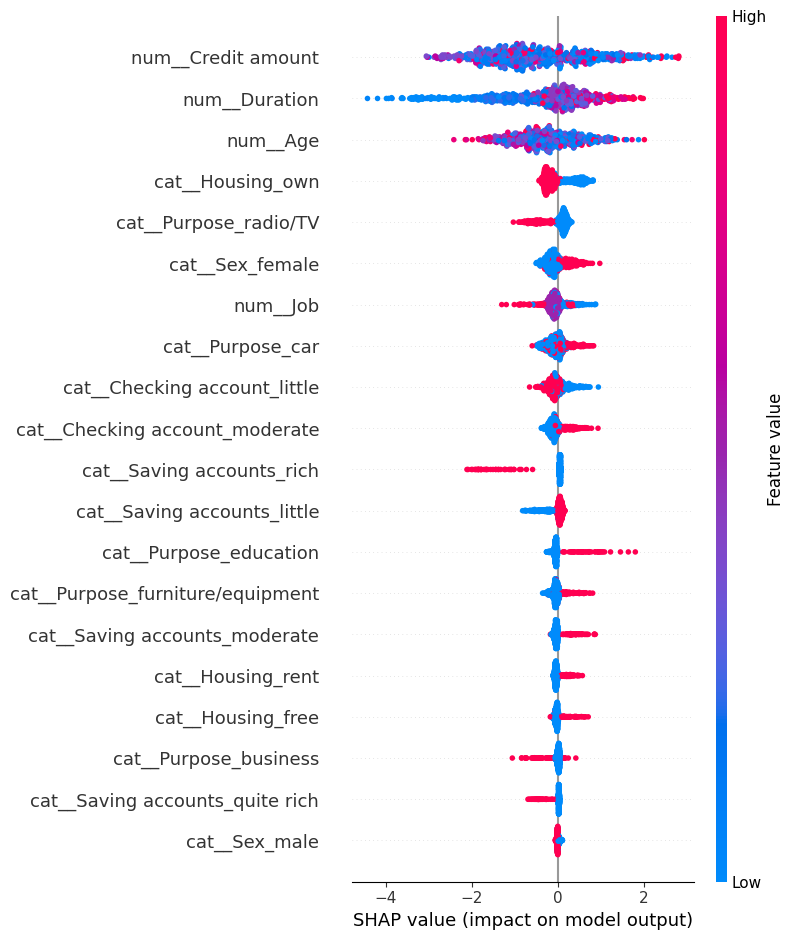

In [32]:
# 10) Explainability with SHAP
best_pipe = best_tuple[1]
best_clf  = best_pipe.named_steps["clf"]
prep      = best_pipe.named_steps["prep"]

best_pipe.fit(X_train, y_train)
Xt = prep.transform(X_train)

if hasattr(prep, "get_feature_names_out"):
    feat_names = prep.get_feature_names_out().tolist()
else:
    feat_names = [f"f_{i}" for i in range(Xt.shape[1])]

idx = np.random.choice(np.arange(Xt.shape[0]), size=min(5000, Xt.shape[0]), replace=False)
Xt_small = Xt[idx]

if isinstance(best_clf, XGBClassifier):
    explainer = shap.TreeExplainer(best_clf)
    shap_values = explainer.shap_values(Xt_small)
else:
    bg = shap.sample(Xt_small, 200, random_state=RANDOM_STATE)
    explainer = shap.KernelExplainer(lambda data: best_clf.predict_proba(data)[:, 1], bg)
    shap_values = explainer.shap_values(shap.sample(Xt_small, 500, random_state=RANDOM_STATE))

shap.initjs()
shap.summary_plot(shap_values, Xt_small, feature_names=feat_names, show=True)


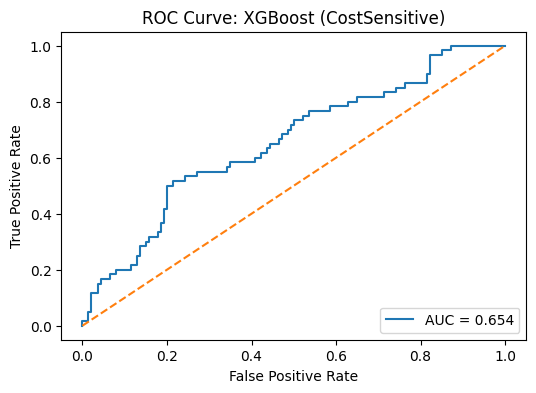

In [33]:
# 11) ROC Curve (Best Model)
proba_best = best_tuple[1].predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, proba_best)
aucv = roc_auc_score(y_test, proba_best)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {aucv:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve: {best_name}"); plt.legend(loc="lower right")
plt.show()


In [34]:
# 12) Save Artifacts (model + leaderboard + requirements)
out_dir = Path("artifacts"); out_dir.mkdir(exist_ok=True, parents=True)

joblib.dump(best_pipe, out_dir / "best_model.joblib")
leader_df.to_csv(out_dir / "leaderboard.csv", index=False)

req = "\n".join([
    "numpy","pandas","scikit-learn","imbalanced-learn",
    "xgboost","shap","matplotlib","joblib"
])
(out_dir / "requirements.txt").write_text(req)

summary = {
    "best_model": best_name,
    "auc_roc": float(leader_df.iloc[0]["auc_roc"]),
    "recall_pos": float(leader_df.iloc[0]["recall_pos"]),
    "mean_recall_cost_sensitive": float(recall_cs),
    "mean_recall_smote": float(recall_sm),
    "relative_recall_improvement_percent": float(impr)
}
(Path(out_dir) / "metrics.json").write_text(json.dumps(summary, indent=2))

print("Saved:", out_dir.resolve())
print(json.dumps(summary, indent=2))


Saved: /content/artifacts
{
  "best_model": "XGBoost (CostSensitive)",
  "auc_roc": 0.6538095238095238,
  "recall_pos": 0.5166666666666667,
  "mean_recall_cost_sensitive": 0.4444444444444445,
  "mean_recall_smote": 0.41111111111111115,
  "relative_recall_improvement_percent": -7.499999999999998
}
